<a href="https://colab.research.google.com/github/sameersundrani/STATS205_FinalProject_Bitcoin/blob/main/Non_ParametricMethods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import requests
import urllib
from collections import Counter
from scipy.interpolate import interp1d
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [ ]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = 'STATS 205 Final Project/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

Mounted at /content/drive


In [ ]:
path_data_600 = "/content/drive/MyDrive/STATS 205 Final Project/BTC_600.csv"
path_data_300 = "/content/drive/MyDrive/STATS 205 Final Project/BTC_300.csv"
path_data_50 = "/content/drive/MyDrive/STATS 205 Final Project/BTC_50.csv"
df_600 = pd.read_csv(path_data_600)
df_300 = pd.read_csv(path_data_300)
df_50 = pd.read_csv(path_data_50)

pre_date_val = list(df_600.iloc[:, 0])
pre_y_val = list(df_600.iloc[:,6])
date_600 = [num for num in pre_date_val]
y_600 = [float(num) for num in pre_y_val]
x_600 = list(range(len(y_600)))
x_600_train = x_600[540:]
x_600 = x_600[:540]
y_600_train = y_600[540:]
y_600 = y_600[:540]

pre_date_val = list(df_300.iloc[:, 0])
pre_y_val = list(df_300.iloc[:, 6])
date_300 = [num for num in pre_date_val]
y_300 = [float(num) for num in pre_y_val]
x_300 = list(range(len(y_300)))
x_300_train = x_300[270:]
x_300 = x_300[:270]
y_300_train = y_300[270:]
y_300 = y_300[:270]

pre_date_val = list(df_50.iloc[:, 0])
pre_y_val = list(df_50.iloc[:, 6])
date_50 = [num for num in pre_date_val]
y_50 = [float(num) for num in pre_y_val]
x_50 = list(range(len(y_50)))
x_50_train = x_50[40:]
x_50 = x_50[:40]
y_50_train = y_50[40:]
y_50 = y_50[:40]

datasets_2 = [(x_600 + x_600_train, y_600 + y_600_train), (x_300 + x_300_train, y_300 + y_300_train), (x_50 + x_50_train, y_50 + y_50_train)][::-1]
datasets = [(x_600, y_600, x_600_train, y_600_train),(x_300, y_300, x_300_train, y_300_train),(x_50, y_50, x_50_train, y_50_train)][::-1]
#datasets = reversed(datasets)
#print(datasets)
path_to_save = "/content/drive/MyDrive/STATS 205 Final Project/"

# Regressogram 

In [ ]:
def get_bin_boundaries(a, b, m):
    bound_size = float((b - a)/m)
    bound_list = []
    curBound = a
    for i in range(m):
        bound_list.append((curBound, curBound + bound_size)) 
        curBound += bound_size
    return bound_list

def bin_all_in_vec(bin_list, vec_to_bin):
    fin_bin_list = []
    for i in range(len(vec_to_bin)):
        for j in range(len(bin_list)):
            if bin_list[j][0] <= vec_to_bin[i] <= bin_list[j][1]: 
                fin_bin_list.append(j)
    return fin_bin_list

def get_r_hat(bin_list, pred_vec, num_bins):
  rhats_per_bin = []
  for i in range(num_bins):
    curBinList = []
    for j in range(len(pred_vec)):
      #print(j)    
      if bin_list[j] == i:
        curBinList.append(pred_vec[j])
    if(len(curBinList) != 0):
      rhats_per_bin.append(sum(curBinList)/len(curBinList))
  return rhats_per_bin

def f_rhat(x, bin_tups, r_hats):
    if x < bin_tups[0][0]:
        return r_hats[0]
    if x > bin_tups[len(bin_tups) - 1][1]:
        return r_hats[len(bin_tups) - 1]
    for i in range(len(bin_tups)):
        if bin_tups[i][0] <= x <= bin_tups[i][1]:
            return r_hats[i]

def calculate_regressogram(x,y,m,s):
  min_x, max_x = min(x), max(x)
  bounds = get_bin_boundaries(min_x, max_x+.01, m)
  bins = bin_all_in_vec(bounds, x)
  r_hat = get_r_hat(bins, y, m)
  steps = [min_x]
  start = min_x
  size = float((max_x - min_x)/s)
  for i in range(s):
    steps.append(start + size)
    start += size
  r_hat_all = [r_hat[bins[i]] for i in range(len(bins))]
  f_hat = [f_rhat(i, bounds, r_hat) for i in steps] 
  return f_hat, steps

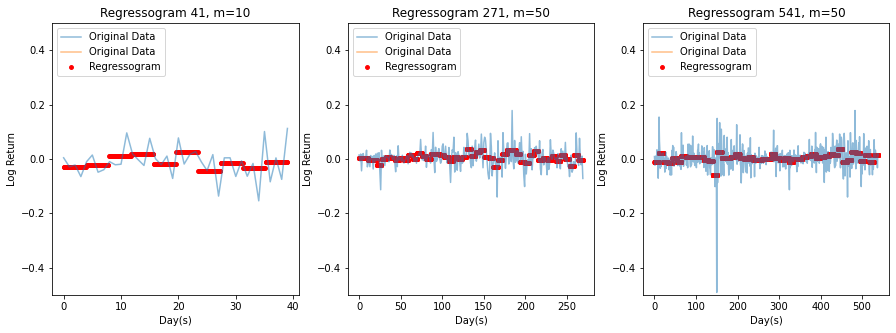

In [ ]:
fig, axis = plt.subplots(1, 3, figsize=(15,5))
r = 0
#for m in [5,10,20]:
for m in [(50,10)]:
  for i in range(len(datasets)):
    x,y,_,_ = datasets[i]
    m_used = m[0] if len(x) > 50 else m[1]
    size = len(x) * 10
    f_hat, steps = calculate_regressogram(x,y,m_used,size)
    axis[i].scatter(steps, f_hat, 15, label = "Regressogram", color= 'red')
    axis[i].plot(x, y,2, alpha = 0.5, label = "Original Data")
    axis[i].set_title("Regressogram " + str(len(x) + 1) + ", m=" + str(m_used) )
    axis[i].set_xlabel("Day(s)")
    axis[i].set_ylabel("Log Return")
    axis[i].set_ylim([-.5,.5])
    #plt.title("Glass Data")
    axis[i].legend(loc="upper left")
  r += 1

plt.savefig(path_to_save + "Regressogram.jpg")

# Local Averaging

In [ ]:
def get_local_tups(orig_vec, h):
    local_tups = []
    for i in range(len(orig_vec)):
        local_tups.append((orig_vec[i] - h, orig_vec[i] + h))
    return local_tups

def get_r_hat_local(orig_vec, loc_tups, pred_vec):
    r_hat = []
    for i in range(len(loc_tups)):
        local_vec = []
        for j in range(len(orig_vec)):
            if loc_tups[i][0] <= orig_vec[j] <= loc_tups[i][1]: 
                local_vec.append(pred_vec[j])
        r_hat.append(sum(local_vec)/len(local_vec))
    return r_hat

def local_avg(x,y,h):
  local_bins = get_local_tups(x,h)
  local_rhat = get_r_hat_local(x, local_bins, y)
  return local_rhat

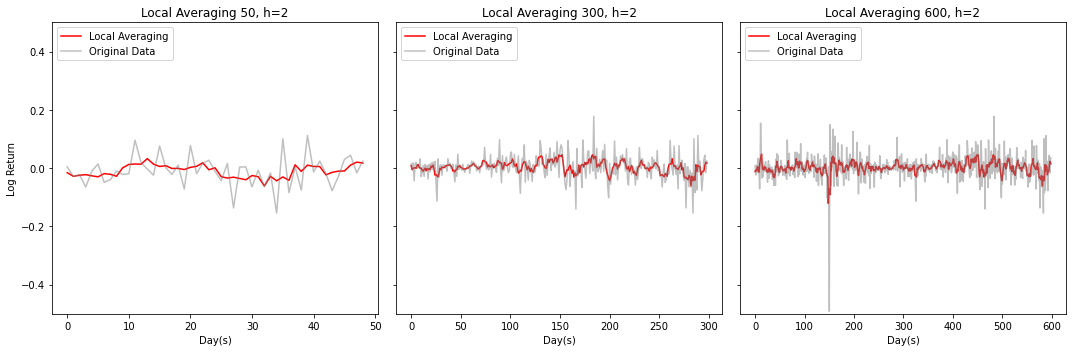

In [ ]:
fig, axis = plt.subplots(1, 3,sharey = True, figsize=(15,5))
r = 0
#for h in [1,2.5,5]:
for h in[2]:
  for i in range(len(datasets_2)):
    x,y = datasets_2[i]
    local_f_hat = local_avg(x,y,h)
    axis[i].plot(x, local_f_hat, label = "Local Averaging", color= 'red')
    axis[i].plot(x, y, alpha = 0.5, label = "Original Data", color='grey')
    axis[i].set_title("Local Averaging " + str(len(x) + 1) + ", h=" + str(h) )
    axis[i].set_xlabel("Day(s)")
    #axis[i].set_ylabel("Log Return")
    axis[i].set_ylim([-.5,.5])
    axis[i].legend(loc="upper left")
  r += 1
axis[0].set_ylabel("Log Return")
fig.tight_layout()
plt.savefig(path_to_save + "Local Averaging.jpg")

# Linear Interpolation

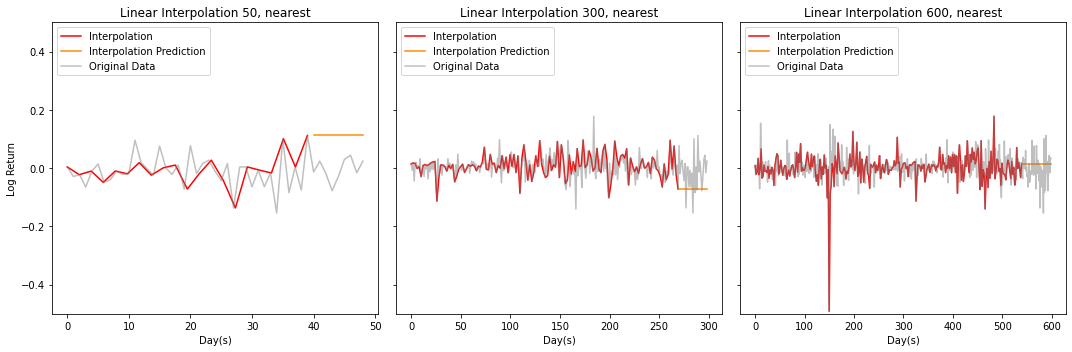

In [ ]:
#x = np.linspace(0, 10, num=11, endpoint=True)
#y = np.cos(-x**2/9.0)
#f1 = interp1d(x, y, kind='nearest',fill_value="extrapolate")
#f2 = interp1d(x, y, kind='cubic',fill_value="extrapolate")
#f3 = interp1d(x, y, kind='slinear',fill_value="extrapolate")

fig, axis = plt.subplots(1, 3, sharey=True, figsize=(15,5))
#r = 0
#for h in ['nearest', 'cubic', 'slinear']:
for h in ['nearest']:
  for i in range(len(datasets)):
    x,y,x_train,y_train = datasets[i]
    f = interp1d(x, y, kind=h,fill_value="extrapolate")
    min_x, max_x = min(x), max(x)
    steps = [min_x]
    start = min_x
    size = float((max_x - min_x)/(.5 * len(x)))
    for j in range(int(.5 * len(x))):
      steps.append(start + size)
      start += size
    
    #step_2 = [start]
    min_x, max_x = min(x_train), max(x_train)
    step_2 = [min_x]
    start = min_x
    size = float((max_x - min_x)/(2 * len(x_train)))
    for j in range(int(2 * len(x_train))):
      step_2.append(start + size)
      start += size
    #print(step_2)
    axis[i].plot(steps, f(steps), label = "Interpolation", color= 'red')
    axis[i].plot(step_2, f(step_2), label = "Interpolation Prediction", color= 'darkorange')
    axis[i].plot(x + x_train, y + y_train, alpha = 0.5, label = "Original Data", color='grey')
    axis[i].set_title("Linear Interpolation " + str(len(x) + len(x_train) + 1)+ ", "+ str(h) )
    axis[i].set_xlabel("Day(s)")
    #axis[i].set_ylim([-.5,.5])
    axis[i].legend(loc="upper left")
  #r += 1
    axis[i].set_ylim([-.5,.5])
axis[0].set_ylabel("Log Return")
fig.tight_layout()
plt.savefig(path_to_save + "Interpolation.jpg")

# LSTM

In [ ]:


#for i in datasets_2:
dfs = [(path_data_50,1), (path_data_300,15), (path_data_600,25)]
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)
# fix random seed for reproducibility
np.random.seed(7)
test_size = 0
# load the dataset
fig, axis = plt.subplots(1,3, sharey=True, figsize=(15,5))
r = 0
for num, i in enumerate(dfs):
  dataframe = pd.read_csv(i[0], usecols=[6], engine='python')
  dataset = dataframe.values
  dataset = dataset.astype('float32')
  # normalize the dataset
  scaler = MinMaxScaler(feature_range=(0, 1))
  dataset = scaler.fit_transform(dataset)
  # split into train and test sets
  train_size = int(len(dataset) * 0.80)
  test_size = len(dataset) - train_size
  train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
  # reshape into X=t and Y=t+1
  look_back = i[1]
  trainX, trainY = create_dataset(train, look_back)
  testX, testY = create_dataset(test, look_back)
  # reshape input to be [samples, time steps, features]
  trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
  testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
  # create and fit the LSTM network
  model = Sequential()
  model.add(LSTM(4, input_shape=(1, look_back)))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer='adam')
  model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
  # make predictions
  trainPredict = model.predict(trainX)
  testPredict = model.predict(testX)
  # invert predictions
  trainPredict = scaler.inverse_transform(trainPredict)
  trainY = scaler.inverse_transform([trainY])
  testPredict = scaler.inverse_transform(testPredict)
  testY = scaler.inverse_transform([testY])
  # calculate root mean squared error
  trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
  print('Train Score: %.2f RMSE' % (trainScore))
  testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
  print('Test Score: %.2f RMSE' % (testScore))
  # shift train predictions for plotting
  trainPredictPlot = np.empty_like(dataset)
  trainPredictPlot[:, :] = np.nan
  trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
  # shift test predictions for plotting
  testPredictPlot = np.empty_like(dataset)
  testPredictPlot[:, :] = np.nan
  testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
  # plot baseline and predictions
  axis[num].plot(scaler.inverse_transform(dataset), label = "Data", color='grey')
  axis[num].plot(trainPredictPlot, label = "Train", color= 'red')
  axis[num].plot(testPredictPlot,  label = "Prediction", color= 'darkorange')
  axis[num].set_title("LSTM " + str(len(dataset) + 1)+ ", Lookback = "+ str(look_back) )
  axis[num].set_xlabel("Day(s)")
  axis[num].legend(loc="upper left")
    #if i != 2: test_size = len(dfs[i+1]) - len(dfs[i+1]) * .9
  #axis[num].show()
  axis[num].set_ylim([-.5,.5])
axis[0].set_ylabel("Log Return")
fig.tight_layout()
plt.savefig(path_to_save + "LSTM.jpg")

Epoch 1/100
37/37 - 2s - loss: 0.4446
Epoch 2/100
37/37 - 0s - loss: 0.3589
Epoch 3/100
37/37 - 0s - loss: 0.2864
Epoch 4/100
37/37 - 0s - loss: 0.2245
Epoch 5/100
37/37 - 0s - loss: 0.1716
Epoch 6/100
37/37 - 0s - loss: 0.1288
Epoch 7/100
37/37 - 0s - loss: 0.0941
Epoch 8/100
37/37 - 0s - loss: 0.0707
Epoch 9/100
37/37 - 0s - loss: 0.0538
Epoch 10/100
37/37 - 0s - loss: 0.0450
Epoch 11/100
37/37 - 0s - loss: 0.0385
Epoch 12/100
37/37 - 0s - loss: 0.0355
Epoch 13/100
37/37 - 0s - loss: 0.0336
Epoch 14/100
37/37 - 0s - loss: 0.0324
Epoch 15/100
37/37 - 0s - loss: 0.0319
Epoch 16/100
37/37 - 0s - loss: 0.0312
Epoch 17/100
37/37 - 0s - loss: 0.0308
Epoch 18/100
37/37 - 0s - loss: 0.0301
Epoch 19/100
37/37 - 0s - loss: 0.0297
Epoch 20/100
37/37 - 0s - loss: 0.0293
Epoch 21/100
37/37 - 0s - loss: 0.0287
Epoch 22/100
37/37 - 0s - loss: 0.0282
Epoch 23/100
37/37 - 0s - loss: 0.0279
Epoch 24/100
37/37 - 0s - loss: 0.0272
Epoch 25/100
37/37 - 0s - loss: 0.0268
Epoch 26/100
37/37 - 0s - loss: 0.

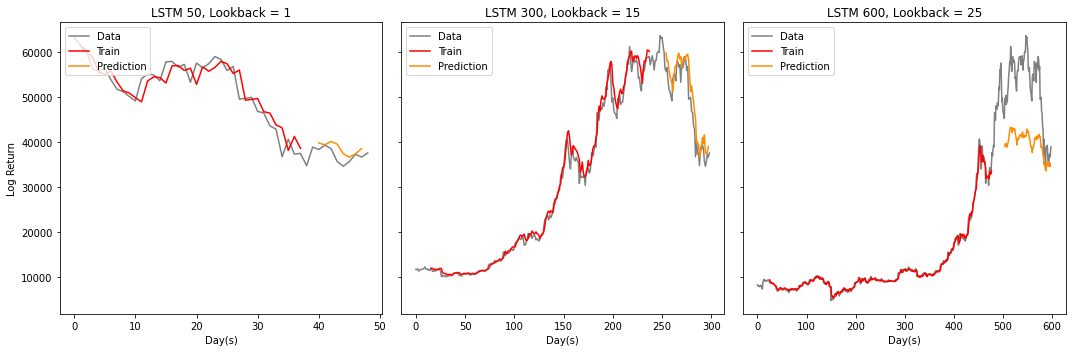

In [ ]:
#for i in datasets_2:
dfs = [(path_data_50,1), (path_data_300,15), (path_data_600,25)]
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)
# fix random seed for reproducibility
np.random.seed(7)
test_size = 0
# load the dataset
fig, axis = plt.subplots(1,3, sharey=True, figsize=(15,5))
r = 0
for num, i in enumerate(dfs):
  dataframe = pd.read_csv(i[0], usecols=[4], engine='python')
  dataset = dataframe.values
  dataset = dataset.astype('float32')
  # normalize the dataset
  scaler = MinMaxScaler(feature_range=(0, 1))
  dataset = scaler.fit_transform(dataset)
  # split into train and test sets
  train_size = int(len(dataset) * 0.80)
  test_size = len(dataset) - train_size
  train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
  # reshape into X=t and Y=t+1
  look_back = i[1]
  trainX, trainY = create_dataset(train, look_back)
  testX, testY = create_dataset(test, look_back)
  # reshape input to be [samples, time steps, features]
  trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
  testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
  # create and fit the LSTM network
  model = Sequential()
  model.add(LSTM(4, input_shape=(1, look_back)))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer='adam')
  model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
  # make predictions
  trainPredict = model.predict(trainX)
  testPredict = model.predict(testX)
  # invert predictions
  trainPredict = scaler.inverse_transform(trainPredict)
  trainY = scaler.inverse_transform([trainY])
  testPredict = scaler.inverse_transform(testPredict)
  testY = scaler.inverse_transform([testY])
  # calculate root mean squared error
  trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
  print('Train Score: %.2f RMSE' % (trainScore))
  testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
  print('Test Score: %.2f RMSE' % (testScore))
  # shift train predictions for plotting
  trainPredictPlot = np.empty_like(dataset)
  trainPredictPlot[:, :] = np.nan
  trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
  # shift test predictions for plotting
  testPredictPlot = np.empty_like(dataset)
  testPredictPlot[:, :] = np.nan
  testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
  # plot baseline and predictions
  axis[num].plot(scaler.inverse_transform(dataset), label = "Data", color='grey')
  axis[num].plot(trainPredictPlot, label = "Train", color= 'red')
  axis[num].plot(testPredictPlot,  label = "Prediction", color= 'darkorange')
  axis[num].set_title("LSTM " + str(len(dataset) + 1)+ ", Lookback = "+ str(look_back) )
  axis[num].set_xlabel("Day(s)")
  axis[num].legend(loc="upper left")
    #if i != 2: test_size = len(dfs[i+1]) - len(dfs[i+1]) * .9
  #axis[num].show()
  #axis[num].set_ylim([-.5,.5])
axis[0].set_ylabel("Log Return")
fig.tight_layout()
#plt.savefig(path_to_save + "LSTM.jpg")